In [1]:
# Library import
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout, Input, MaxPool2D, Activation, GlobalAveragePooling2D
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras import models, layers, optimizers
from keras.callbacks import ReduceLROnPlateau

In [2]:
# Get Image directories
base_dir = 'Landscapes'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# Create Image Generato
datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True, validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Get images from train
train_data = datagen.flow_from_directory(
							train_dir,
							target_size = (224, 224),
							batch_size = 32,
							class_mode ='categorical',
                            subset="training")

Found 11230 images belonging to 6 classes.


In [5]:
# Get images from validation with 0.20 split 
val_data = datagen.flow_from_directory(
							train_dir,
							target_size = (224, 224),
							batch_size = 32,
							class_mode ='categorical',
                            subset="validation")

Found 2804 images belonging to 6 classes.


In [6]:
# Get images from test
test_data = test_datagen.flow_from_directory(
							test_dir,
							target_size = (224, 224),
							batch_size = 32,
							class_mode ='categorical')

Found 3000 images belonging to 6 classes.


In [7]:
# VGG16 transfer learning base
conv_base= VGG16(weights='imagenet',
								include_top=False,
								input_shape = (224,224,3))

conv_base.trainable = False

In [8]:
# Greate a learning rate reduction to avoid over fitting
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

In [9]:
# Creation of first model
VGG16_model = conv_base.output
VGG16_model = Flatten(name="flatten")(VGG16_model)
VGG16_model = Dense(16, activation="relu")(VGG16_model)
VGG16_model = Dense(6, activation="softmax")(VGG16_model)
VGG16_model = Model(conv_base.input, VGG16_model)

In [10]:
# Print model summary
VGG16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# Compile model
VGG16_model.compile(loss = "categorical_crossentropy", optimizer = tf.optimizers.Adam(2e-5), metrics = ["acc"])

In [12]:
# Train model
history = VGG16_model.fit(train_data,
                    steps_per_epoch = 150,
                    epochs = 20,
                   validation_data = val_data)

Epoch 1/20
150/150 [==============================] - 150s 905ms/step - loss: 1.4845 - acc: 0.4358 - val_loss: 1.2220 - val_acc: 0.5785
Epoch 2/20
150/150 [==============================] - 126s 841ms/step - loss: 1.0521 - acc: 0.6633 - val_loss: 0.9412 - val_acc: 0.6937
Epoch 3/20
150/150 [==============================] - 123s 824ms/step - loss: 0.8379 - acc: 0.7549 - val_loss: 0.7787 - val_acc: 0.7874
Epoch 4/20
150/150 [==============================] - 128s 856ms/step - loss: 0.7081 - acc: 0.8058 - val_loss: 0.6809 - val_acc: 0.7921
Epoch 5/20
150/150 [==============================] - 117s 779ms/step - loss: 0.6240 - acc: 0.8160 - val_loss: 0.6050 - val_acc: 0.8103
Epoch 6/20
150/150 [==============================] - 115s 770ms/step - loss: 0.5639 - acc: 0.8318 - val_loss: 0.5516 - val_acc: 0.8352
Epoch 7/20
150/150 [==============================] - 114s 759ms/step - loss: 0.5214 - acc: 0.8369 - val_loss: 0.5255 - val_acc: 0.8374
Epoch 8/20
150/150 [============================

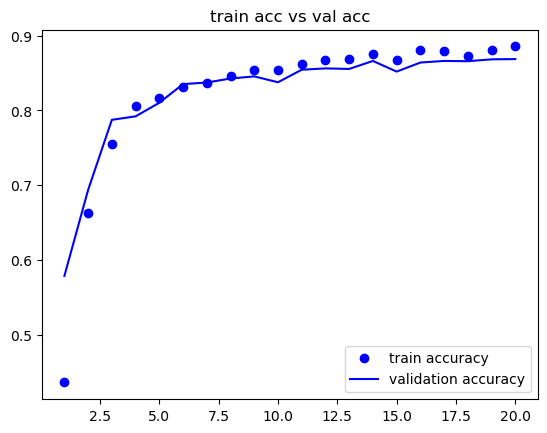

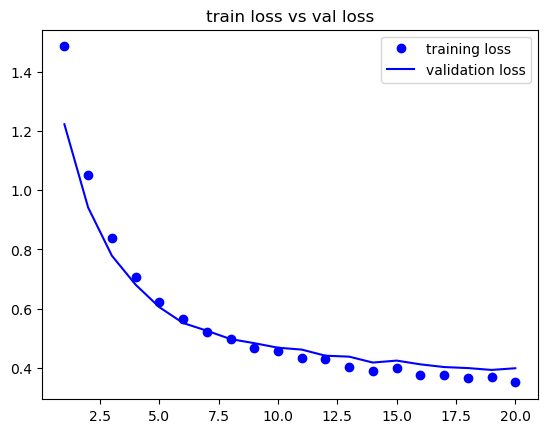

In [13]:
# Plotting results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

Eventhough the loss is decreasing, after a certain point the model doesnt improve its accuracy, so we need no make some adjustments. 

In [14]:
# Creation of second model
VGG16_model2 = conv_base.output
VGG16_model2 = Flatten(name="flatten")(VGG16_model2)
VGG16_model2 = Dense(64, activation="relu")(VGG16_model2)
VGG16_model2 = Dense(64, activation="relu")(VGG16_model2)
VGG16_model2 = Dropout(0.3)(VGG16_model2)
VGG16_model2 = Dense(6, activation="softmax")(VGG16_model2)
VGG16_model2 = Model(conv_base.input, VGG16_model2)

In [15]:
# Second model compile
VGG16_model2.compile(loss = "categorical_crossentropy", optimizer = tf.optimizers.Adam(2e-5), metrics = ["acc"])

In [16]:
# Summary of second model
VGG16_model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [17]:
# Training of second model incluiding the learning rate reduction
history = VGG16_model2.fit(train_data,
                    steps_per_epoch = 150,
                    epochs = 20,
                    verbose = 1,
                    validation_data = val_data,
                    callbacks=[lr_reduction])

Epoch 1/20
150/150 [==============================] - 103s 678ms/step - loss: 1.3162 - acc: 0.5050 - val_loss: 0.9293 - val_acc: 0.7643
Epoch 2/20
150/150 [==============================] - 110s 734ms/step - loss: 0.8691 - acc: 0.7072 - val_loss: 0.6900 - val_acc: 0.8071
Epoch 3/20
150/150 [==============================] - 109s 729ms/step - loss: 0.7406 - acc: 0.7420 - val_loss: 0.5832 - val_acc: 0.8203
Epoch 4/20
150/150 [==============================] - 95s 635ms/step - loss: 0.6289 - acc: 0.7830 - val_loss: 0.5259 - val_acc: 0.8274
Epoch 5/20
150/150 [==============================] - 89s 593ms/step - loss: 0.5758 - acc: 0.8003 - val_loss: 0.4832 - val_acc: 0.8442
Epoch 6/20
150/150 [==============================] - 86s 575ms/step - loss: 0.5371 - acc: 0.8181 - val_loss: 0.4551 - val_acc: 0.8520
Epoch 7/20
150/150 [==============================] - 89s 592ms/step - loss: 0.4995 - acc: 0.8281 - val_loss: 0.4329 - val_acc: 0.8495
Epoch 8/20
150/150 [==============================] 

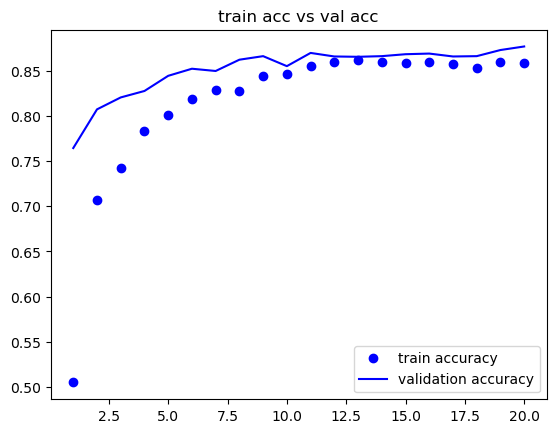

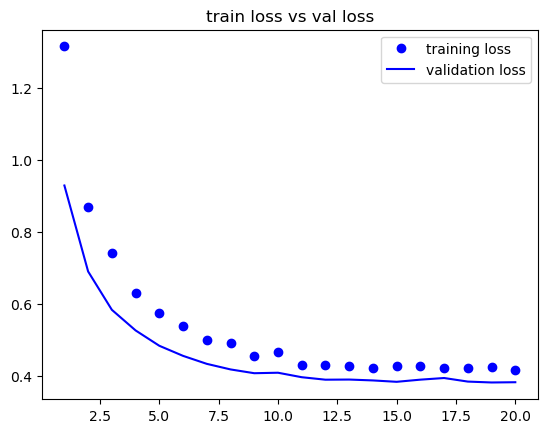

In [18]:
# Plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

We can see an improvement but we still need to check the accuracy of the two models, to decide which one os better

In [19]:
# Get steps size test
steps_size_test = test_data.n//test_data.batch_size

In [23]:
# Evaluate first model with test
test_loss, test_acc = VGG16_model.evaluate(test_data, steps = 3)
print('\nTest Accuracy First Model:\n', test_acc)

3/3 [==============================] - 1s 288ms/step - loss: 0.3903 - acc: 0.8854

Test Accuracy First Model:
 0.8854166865348816


In [22]:
# Evaluate second model with test
test_loss, test_acc = VGG16_model2.evaluate(test_data, steps = 3)
print('\nTest Accuray Second Model:\n', test_acc)

3/3 [==============================] - 1s 302ms/step - loss: 0.3543 - acc: 0.8958

Test Accuray Second Model:
 0.8958333134651184


In [24]:
# Save model with best accuracy
VGG16_model2.save('best_model_VGG16.h5')

In [25]:
# Load model to make predictions
best_model_loaded = models.load_model("best_model_VGG16.h5")

In [26]:
# Function for predictions
def predict(img_rel_path):
    # Import Image from the path
    img = image.load_img(img_rel_path, target_size=(224, 224))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values
    img = np.array(img)/255.0

    # Plotting the original image
    plt.title("Image to predict")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the label of the predicition
    p = best_model_loaded.predict(img[np.newaxis, ...])

    # Labels 
    labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

    # Printing the results 
    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classification:", predicted_class, "\n")

    classes=[]
    probability=[]

    # Get individual probability to see possible errors
    print("\nIndividual Probability:")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        probability.append(round(j*100,2))

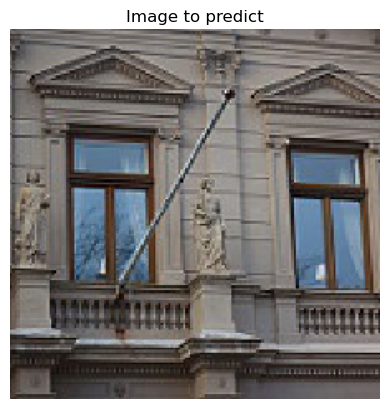



Maximum Probability:  0.95468324
Classification: buildings 


Individual Probability:
BUILDINGS : 95.47 %
FOREST : 0.04 %
GLACIER : 0.11 %
MOUNTAIN : 0.28 %
SEA : 0.06 %
STREET : 4.04 %


In [28]:
# Buildings class predictions
predict("Landscapes/test/buildings/20096.jpg")

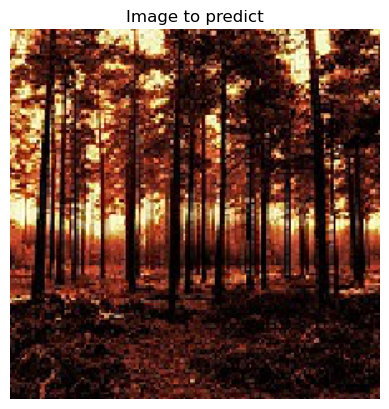



Maximum Probability:  0.980684
Classification: forest 


Individual Probability:
BUILDINGS : 0.41 %
FOREST : 98.07 %
GLACIER : 0.02 %
MOUNTAIN : 0.22 %
SEA : 0.14 %
STREET : 1.15 %


In [30]:
# Forest class predictions
predict("Landscapes/test/forest/20134.jpg")

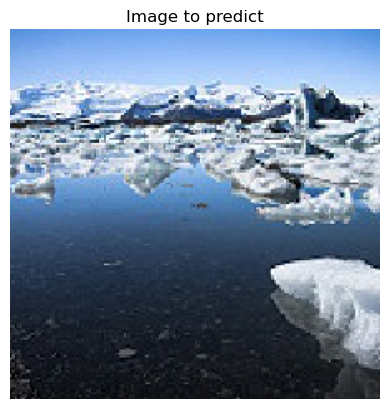



Maximum Probability:  0.47022802
Classification: glacier 


Individual Probability:
BUILDINGS : 1.05 %
FOREST : 1.23 %
GLACIER : 47.02 %
MOUNTAIN : 22.79 %
SEA : 26.29 %
STREET : 1.62 %


In [32]:
# Glacier predicions
predict("Landscapes/test/glacier/20202.jpg")

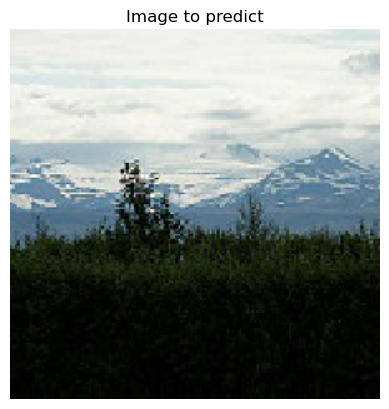



Maximum Probability:  0.65815294
Classification: mountain 


Individual Probability:
BUILDINGS : 0.65 %
FOREST : 3.02 %
GLACIER : 11.1 %
MOUNTAIN : 65.82 %
SEA : 18.17 %
STREET : 1.24 %


In [34]:
# Mountain class predicions
predict("Landscapes/test/mountain/20129.jpg")

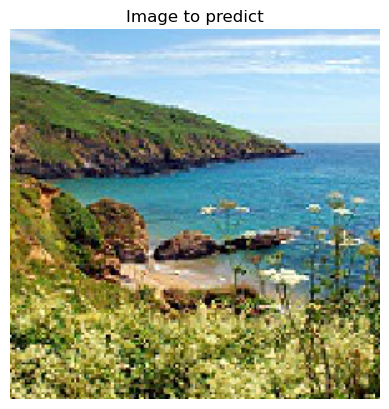



Maximum Probability:  0.43455842
Classification: sea 


Individual Probability:
BUILDINGS : 0.26 %
FOREST : 1.23 %
GLACIER : 13.04 %
MOUNTAIN : 41.78 %
SEA : 43.46 %
STREET : 0.23 %


In [37]:
# Sea class predicions
predict("Landscapes/test/sea/20138.jpg")

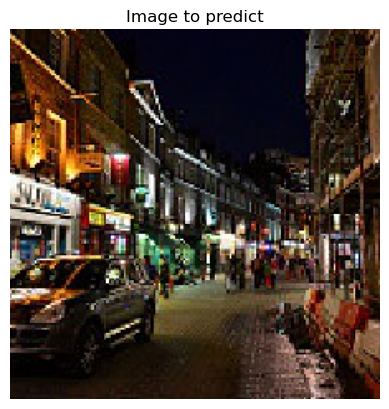



Maximum Probability:  0.9981774
Classification: street 


Individual Probability:
BUILDINGS : 0.17 %
FOREST : 0.0 %
GLACIER : 0.0 %
MOUNTAIN : 0.01 %
SEA : 0.0 %
STREET : 99.82 %


In [39]:
# Street class predictions
predict("Landscapes/test/street/20259.jpg")